In [2]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if base_path not in sys.path:
    sys.path.append(base_path)

import express.config as config
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.utils import add_names

In [3]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)
game_id = 3895302

df_actions = add_names(train_db.actions(game_id))
#display max columns
df_press=df_actions[df_actions["type_name"] == "pressing"]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x000001F24E939BE0>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x000001F24F920050>


### 1 부채꼴 영역 내에서, 패스 경로를 방해하는 인원의 가우시안 분포 구하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from mplsoccer import Pitch
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
class SectorAnalysis:
    def __init__(self, ball_x, ball_y, freeze_frame, angle=45, player_idx=0,visualize=False):
        self.freeze_frame = freeze_frame
        self.angle = angle        

        self.teammate = freeze_frame[player_idx]        
        self.visualize = visualize
        self.opponents_in_sector = []
        self.Z = None
        self.ball_x = ball_x
        self.ball_y = ball_y
        
    
    def draw_pitch(self):
        if not self.visualize:
            return
        pitch = Pitch(pitch_type='custom', pitch_width=68, pitch_length=105, label=True, pitch_color='grass', line_color='white')
        fig, ax = pitch.draw()

        
        for idx, player in enumerate(self.freeze_frame):
            x, y = player['x'], player['y']
            if player['teammate']:
                pitch.scatter(x, y, s=100, c='red', marker='o', ax=ax)  # 압박 팀의 팀원 표시
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가
            else:
                pitch.scatter(x, y, s=100, c='blue', marker='o', ax=ax)  # (공격팀)상대 선수 표시
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가
        
        pitch.scatter(self.ball_x, self.ball_y, s=50, c='gold', edgecolors='black', marker='*', ax=ax, zorder=5)
        ax.text(self.ball_x, self.ball_y, "p", fontsize=8, color='black', ha='center', va='center')  # 공 레이블 추가

        # 부채꼴 그리기
        teammate_x, teammate_y = self.teammate['x'], self.teammate['y']
        distance = ((teammate_x - self.ball_x) ** 2 + (teammate_y - self.ball_y) ** 2) ** 0.5
        direction_angle = np.degrees(np.arctan2(teammate_y - self.ball_y, teammate_x - self.ball_x))
        start_angle = direction_angle - self.angle / 2
        end_angle = direction_angle + self.angle / 2

        wedge = Wedge(center=(self.ball_x, self.ball_y), r=distance, theta1=start_angle, theta2=end_angle,
                      color="white", alpha=0.8, edgecolor="black")
        ax.add_patch(wedge)

        plt.show()

    def calculate_opponents_in_sector(self):
        # 부채꼴 내 상대 선수 필터링 및 거리와 각도 계산

        baseline_angle = np.arctan2(self.teammate['y'] - self.ball_y, self.teammate['x'] - self.ball_x)
        distance = ((self.teammate['x'] - self.ball_x) ** 2 + (self.teammate['y'] - self.ball_y) ** 2) ** 0.5
        
        for player in self.freeze_frame:
            if player['teammate']:  # 상대 선수만 필터링
                px, py = player['x'], player['y']
                angle_to_player = np.arctan2(py - self.ball_y, px - self.ball_x)
                angle_diff = angle_to_player - baseline_angle
                angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi

                # 부채꼴 안에 있는 선수 필터링
                if abs(angle_diff) <= np.radians(self.angle / 2):
                    dist_to_player = np.sqrt((px - self.ball_x) ** 2 + (py - self.ball_y) ** 2)
                    if dist_to_player <= distance:
                        self.opponents_in_sector.append((angle_diff, dist_to_player))



    def visualize_opponents(self):
        if not self.visualize:
            return  
        # 부채꼴 안에 있는 상대 선수들의 위치를 시각화
        fig, ax = plt.subplots(figsize=(8, 6))

        distance = ((self.teammate['x'] - self.ball_x) ** 2 + (self.teammate['y'] - self.ball_y) ** 2) ** 0.5
        max_distance = distance + 1  # y축 최대 범위 조정 (필요 시 조정)

        # teammate는 중앙(0, 거리)로 표시
        ax.scatter(0, distance, c='blue', s=200, label="Teammate", edgecolor='black')

        # opponent들을 angle_diff와 거리에 따라 표시
        for angle, dist in self.opponents_in_sector:
            ax.scatter(angle, dist, c='red', s=200, edgecolor='black')
            

        # 축 및 제목 설정
        ax.axvline(0, color='purple', linestyle='--', label='Path of pass')
        ax.set_xlim(-1.5, 1.5)  # x축을 동적으로 설정
        ax.set_ylim(0, max_distance)
        ax.set_xlabel('Angle from pass (radians)')
        ax.set_ylabel('Distance from pass')
        ax.set_title('Opponents in Sector (Angle vs Distance)')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def calculate_gaussian_distribution(self, sigma_x=0.2, sigma_y=3):
        # 각도와 거리 데이터를 기반으로 가우시안 분포 계산 후 그리드에 누적
        angles = np.array([angle for angle, _ in self.opponents_in_sector])
        distances = np.array([dist for _, dist in self.opponents_in_sector])

        x_bins = np.linspace(-1.5, 1.5, 20)
        y_bins = np.linspace(0, 50, 20)
        Z = np.zeros((len(y_bins) - 1, len(x_bins) - 1))


        # 가우시안 분포 계산
        for angle, dist in zip(angles, distances):
            for i in range(len(x_bins) - 1):
                for j in range(len(y_bins) - 1):
                    x_center = (x_bins[i] + x_bins[i + 1]) / 2
                    y_center = (y_bins[j] + y_bins[j + 1]) / 2
                    gaussian = np.exp(-(((x_center - angle) ** 2) / (2 * sigma_x ** 2) +
                                        ((y_center - dist) ** 2) / (2 * sigma_y ** 2)))
                    Z[j, i] += gaussian

        self.Z = Z
        self.x_bins = x_bins
        self.y_bins = y_bins

    def visualize_density(self):
        if not self.visualize:
            return 
        fig, ax = plt.subplots(figsize=(8, 6))
        c = ax.pcolormesh(self.x_bins, self.y_bins, self.Z, cmap='Reds', shading='auto', alpha=0.6)
        fig.colorbar(c, ax=ax)     

        # Opponents와 Teammate 시각화
        ax.scatter(0, ((self.teammate['x'] - self.ball_x)**2 + (self.teammate['y'] - self.ball_y)**2)**0.5,
                   c='blue', s=200, label="Teammate", edgecolor='black', zorder=2)
        for angle, dist in self.opponents_in_sector:
            ax.scatter(angle, dist, c='red', s=200, edgecolor='black', zorder=2)

        # 각 셀의 값을 텍스트로 표시
        for i in range(len(self.x_bins) - 1):
            for j in range(len(self.y_bins) - 1):
                x_center = (self.x_bins[i] + self.x_bins[i + 1]) / 2
                y_center = (self.y_bins[j] + self.y_bins[j + 1]) / 2
                value = self.Z[j, i]
                if value > 0.01:
                    ax.text(x_center, y_center, f'{value:.2f}', color='white', ha='center', va='center', fontsize=8)

        ax.axvline(0, color='purple', linestyle='--', label='Path of pass', zorder=1)
        ax.set_xlim(-1.5, 1.5)

        ax.set_xlabel('Angle from pass (radians)')
        ax.set_ylabel('Distance from pass')
        ax.set_title('Gaussian Distribution of Opponents in Sector (Grid Representation)')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def get_column_sum(self):
        closest_index = np.abs(self.x_bins - 0).argmin()
        column_sum = self.Z[:, closest_index].sum()
        return column_sum
    

    
    

    


### 예시

In [22]:
df_press.head()

original_event_id  period_id  \
game_id action_id                                                    
3895302 6          cfa1f5e1-4e8e-4fc2-bbc8-4df5fdef8283          1   
        11         a43fa179-91f5-4b22-9f74-7f20af0570e4          1   
        17         533ffee0-b9fc-4065-a9db-cb729523d926          1   
        20         c615b3b6-58de-4f77-8190-f0d7f80bbcff          1   
        36         c5957688-d15c-47bf-939d-95333ddc53d4          1   

                   time_seconds  team_id  player_id  start_x  start_y  \
game_id action_id                                                       
3895302 6                 9.637      904      33401  74.3750   55.335   
        11               12.832      904      30606  48.2125   55.845   
        17               15.552      904       8221  44.1875   54.995   
        20               16.383      904       9195  50.0500   51.000   
        36               41.294      176       8784  53.2875   10.625   

                     end_x   end_y  bodypart_id  type_id  result_id  \
game_id action_id                                                     
3895302 6          74.3750  55.335            0       23          0   
        11         48.2125  55.845            0       23          0   
        17         44.1875  54.995            0       23          0   
        20         50.0500  51.000            0       23          0   
        36         53.2875  10.625            0       23          0   

                   possession_team_id play_pattern_name  under_pressure extra  \
game_id action_id                                                               
3895302 6                       176.0     From Kick Off               0    {}   
        11                      176.0     From Kick Off               0    {}   
        17                      176.0     From Kick Off               0    {}   
        20                      176.0     From Kick Off               0    {}   
        36                      904.0      Regular Play               0    {}   

                                                    visible_area_360  \
game_id action_id                                                      
3895302 6          [[55.066665754930455, 23.91276629088182], [55....   
        11         [[49.163592429021435, 27.793803667302768], [43...   
        17         [[43.36676102543239, 24.81271918222688], [32.0...   
        20         [[40.910829695169525, 20.64312315056911], [27....   
        36                                                      None   

                   in_visible_area_360  \
game_id action_id                        
3895302 6                            1   
        11                           1   
        17                           1   
        20                           1   
        36                           0   

                                                    freeze_frame_360  \
game_id action_id                                                      
3895302 6          [{'teammate': False, 'actor': False, 'keeper':...   
        11         [{'teammate': True, 'actor': True, 'keeper': F...   
        17         [{'teammate': True, 'actor': False, 'keeper': ...   
        20         [{'teammate': True, 'actor': False, 'keeper': ...   
        36                                                      None   

                  type_name result_name bodypart_name  
game_id action_id                                      
3895302 6          pressing        fail          foot  
        11         pressing        fail          foot  
        17         pressing        fail          foot  
        20         pressing        fail          foot  
        36         pressing        fail          foot

In [ ]:


    def calculate_column_sum(self, angle=45):
        ''' 
        가능한 패스 경로에 대한 압박 정보를 계산
        '''
        
        teammates = [i for i, player in enumerate(self.frame) if player['teammate'] and not player['actor']]
        column_sums = {}
        
        for idx in teammates:
            try:
                analysis = SectorAnalysis(self.frame, angle=angle, player_idx=idx, visualize=self.visualize)
                analysis.calculate_opponents_in_sector()
                analysis.calculate_gaussian_distribution()
                column_sum = analysis.get_column_sum()
                column_sums[idx] = column_sum
                
                # 추가 시각화
                if self.visualize:
                    self.visualize_all(analysis)  # 모든 시각화 호출
            except ValueError as e:
                print(f"Skipping player at index {idx} - {e}")
        
        return column_sums

Index([0, 3, 4, 6, 8], dtype='int64')

target_idx: 9
0


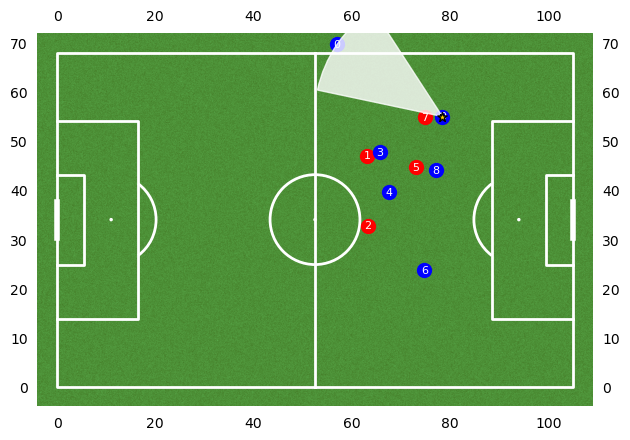

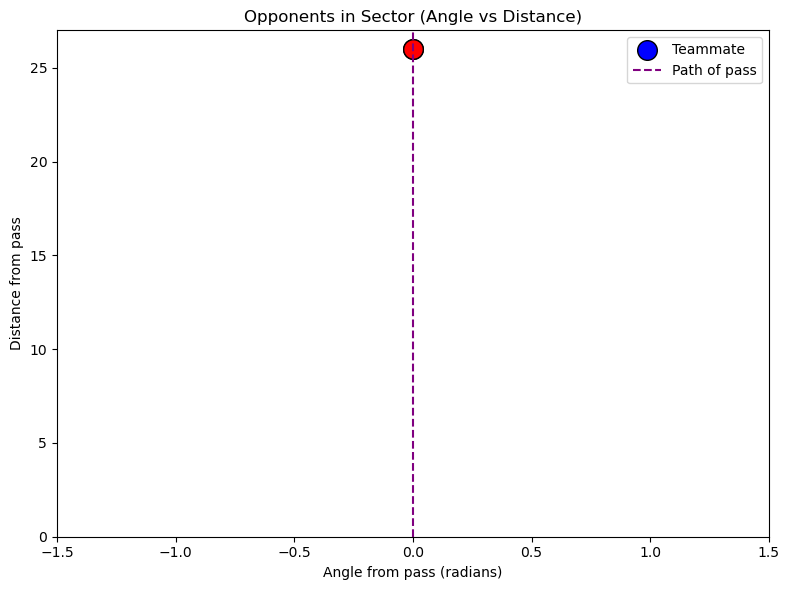

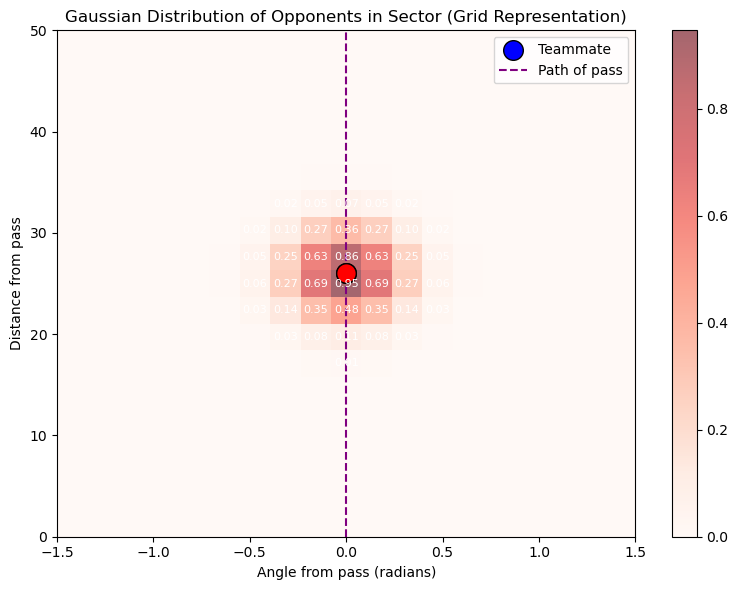

3


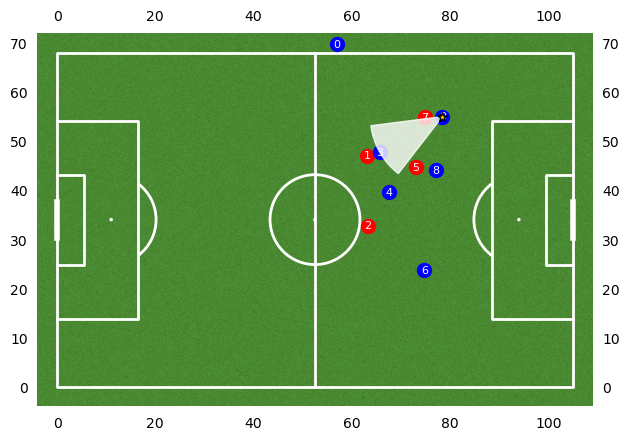

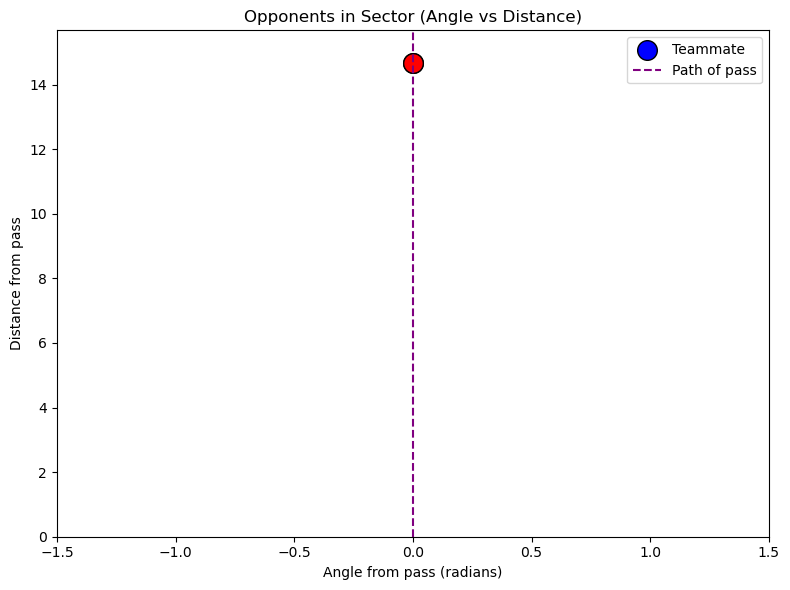

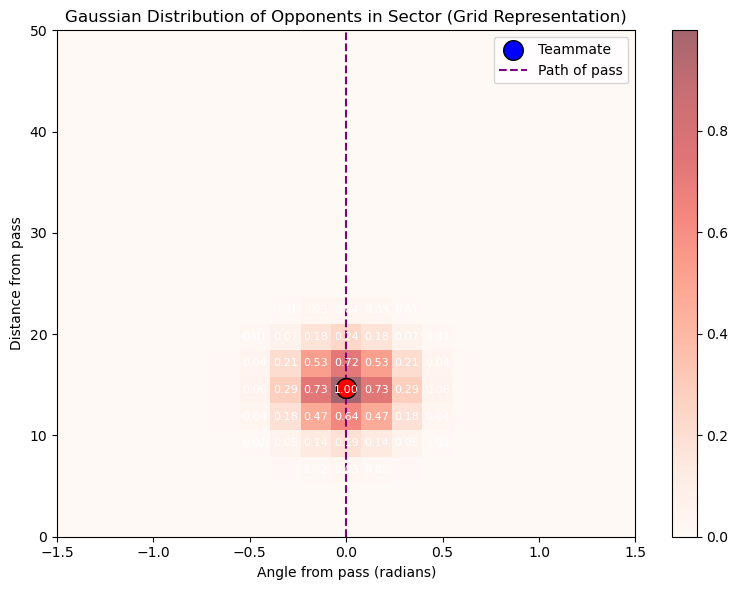

4


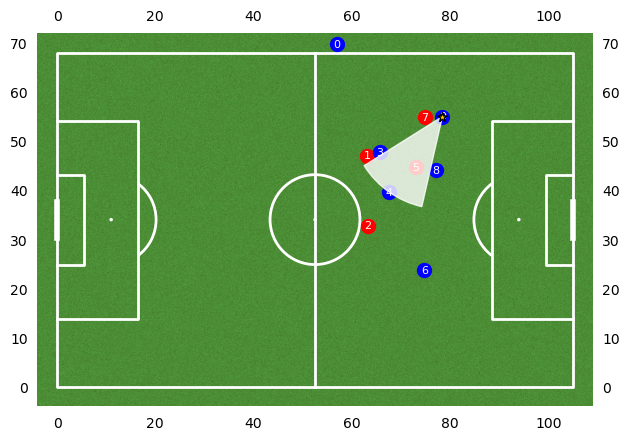

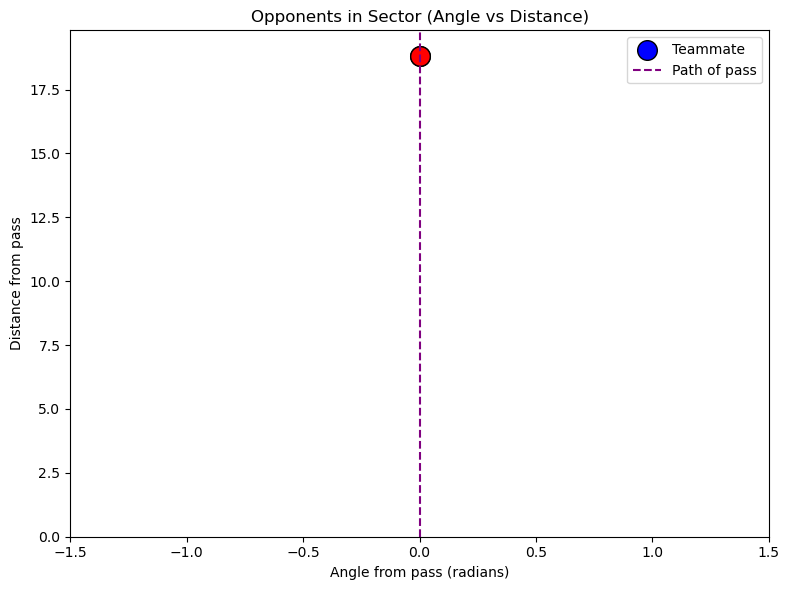

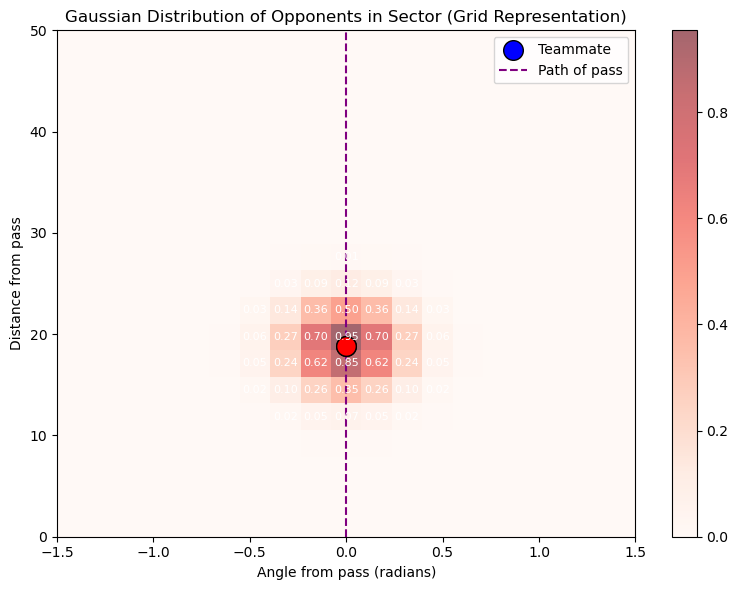

6


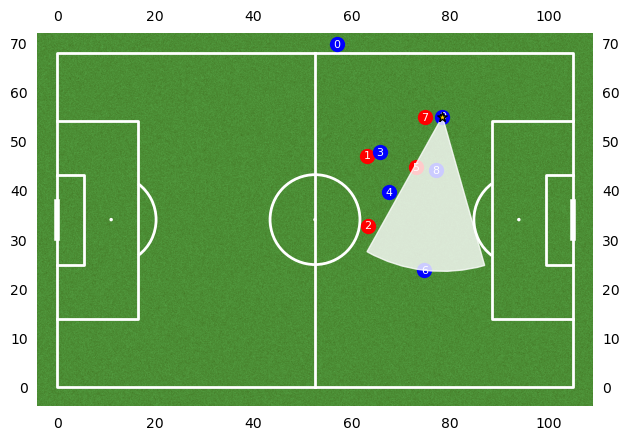

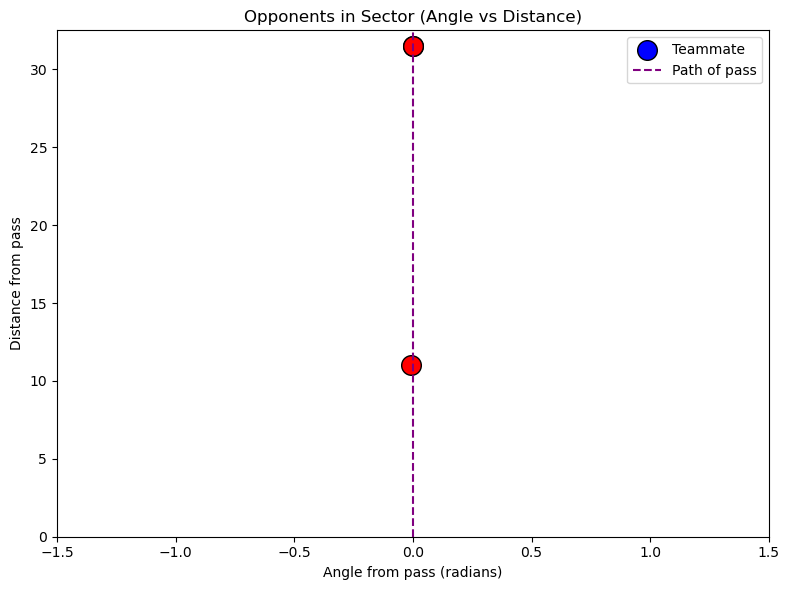

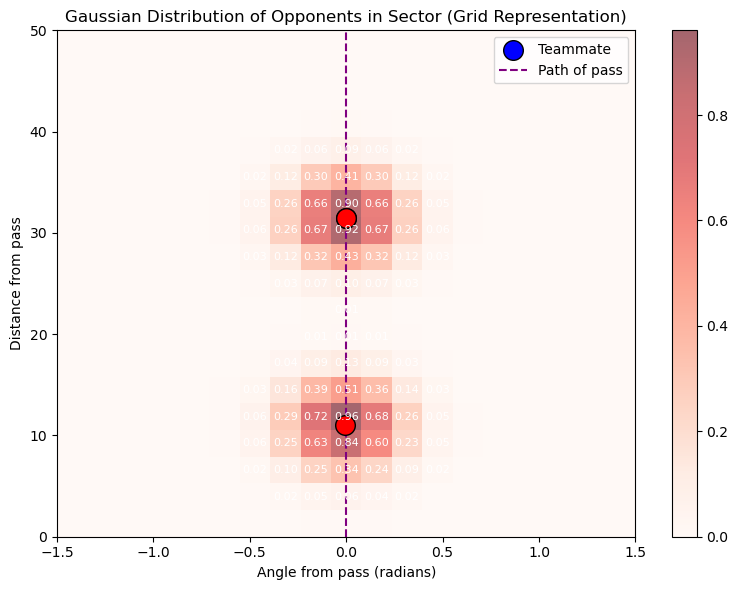

8


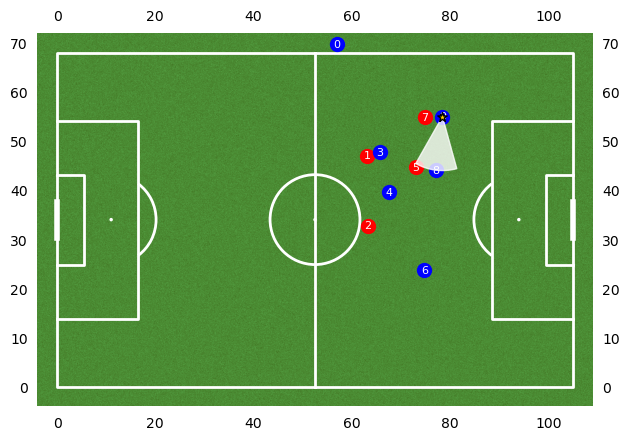

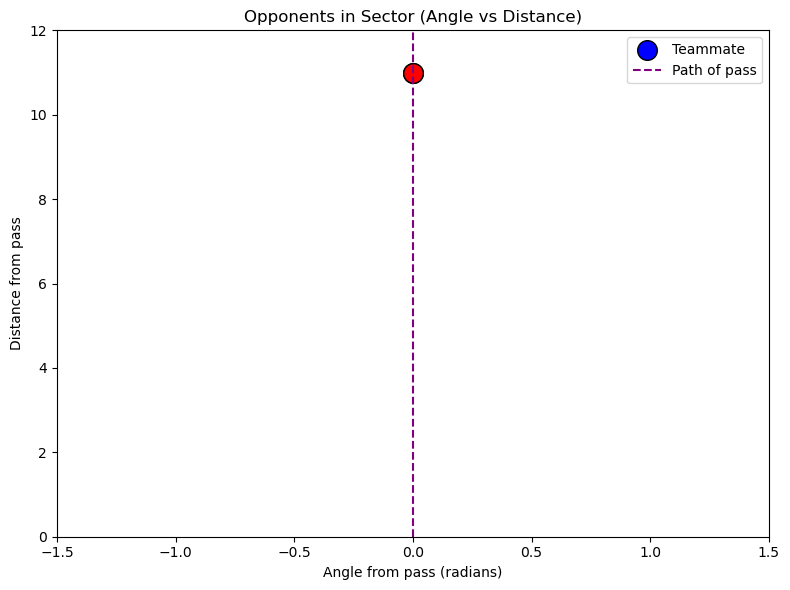

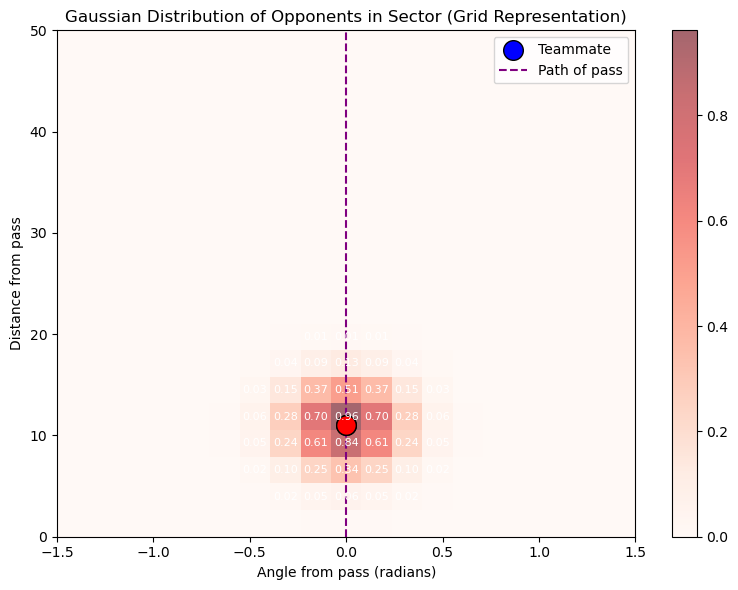

In [49]:
import numpy as np
for i, (_, action) in enumerate(df_press.iterrows()):
    if not action["freeze_frame_360"]:
        continue
    df_freeze_frame = pd.DataFrame.from_records(action["freeze_frame_360"])
    start_x, start_y = action.start_x, action.start_y
    teammate_locs = df_freeze_frame[df_freeze_frame.teammate & ~df_freeze_frame.actor]
    opponent_locs = df_freeze_frame[~df_freeze_frame.teammate]
    dist_presser_to_target = np.sqrt((opponent_locs.x - start_x) ** 2 + (opponent_locs.y - start_y) ** 2)
    target_idx =dist_presser_to_target.idxmin() 
 
    print("target_idx:", target_idx)
    ball_x, ball_y = opponent_locs.loc[target_idx, ["x", "y"]].values
    
    freeze_frame=action["freeze_frame_360"]
    possible_reciever = opponent_locs.index.difference([target_idx])
    for player_idx in possible_reciever:
        print(player_idx)
        sector_analysis = SectorAnalysis(ball_x, ball_y, freeze_frame=freeze_frame, angle=45, player_idx=player_idx, visualize=True)
        sector_analysis.draw_pitch()
        sector_analysis.calculate_opponents_in_sector()
        sector_analysis.visualize_opponents()
        sector_analysis.calculate_gaussian_distribution(sigma_x=0.2, sigma_y=3)
        sector_analysis.visualize_density()
        sector_analysis.get_column_sum()
    break

In [31]:
df_freeze_frame[~df_freeze_frame.teammate]

,teammate,actor,keeper,x,y
0,False,False,False,57.006795,69.699976
3,False,False,False,65.701006,47.690448
4,False,False,False,67.545409,39.645622
6,False,False,False,74.788326,23.689856
8,False,False,False,77.085761,44.070133
9,False,False,False,78.441002,54.986527


In [27]:
opponent_locs

,teammate,actor,keeper,x,y
0,False,False,False,57.006795,69.699976
1,False,False,False,65.701006,47.690448
2,False,False,False,67.545409,39.645622
3,False,False,False,74.788326,23.689856
4,False,False,False,77.085761,44.070133
5,False,False,False,78.441002,54.986527


### 2 나와의 거리 고려

In [38]:
import numpy as np


# actor의 위치 찾기
actor_location = next(player for player in freeze_frame if player['actor'])
actor_x, actor_y = actor_location['x'], actor_location['y']

# 각 teammate와 actor 간의 거리 계산
distances = []
for idx, player in enumerate(freeze_frame):
    if player['teammate'] and not player['actor']:  # actor가 아닌 teammate에 대해서만 계산
        distance = np.sqrt((player['x'] - actor_x) ** 2 + (player['y'] - actor_y) ** 2)
        distances.append({
            'idx': idx,
            'teammate_x': player['x'],
            'teammate_y': player['y'],
            'distance_from_actor': distance
        })

# 결과 출력
for teammate in distances:
    print(f"Teammate_{teammate['idx']} at ({teammate['teammate_x']}, {teammate['teammate_y']}) is {teammate['distance_from_actor']:.2f} units away from the actor.")


Teammate_0 at (38.988571651872256, 28.558231160919767) is 24.84 units away from the actor.
Teammate_1 at (40.523514388280795, 38.90194776671193) is 15.35 units away from the actor.
Teammate_2 at (45.524445034538395, 60.634777790386345) is 11.22 units away from the actor.
Teammate_3 at (45.598842600294375, 54.65495263394877) is 6.37 units away from the actor.
Teammate_4 at (45.870105429864076, 51.44373577695502) is 4.70 units away from the actor.
Teammate_7 at (47.222580100134536, 46.29502314753411) is 5.38 units away from the actor.
Teammate_11 at (52.104376564119875, 39.93087937591656) is 10.77 units away from the actor.
Teammate_13 at (57.3464164219992, 58.77845869679051) is 10.69 units away from the actor.
Teammate_14 at (57.748343526865106, 48.397495623795095) is 7.58 units away from the actor.


### 3 골대와의 거리 고려

In [8]:
import numpy as np

# actor의 위치 찾기
actor_location = next(player for player in freeze_frame if player['actor'])
actor_x, actor_y = actor_location['x'], actor_location['y']
#freeze_frame = df_actions.loc[3895302, "freeze_frame_360"][4]

# game_id로 팀 정보 불러오기
if df_actions.loc[3895302, "freeze_frame_360"][4] == train_db.get_home_away_team_id(game_id)[0]:
    goal_center = (120, 40)  # 홈팀의 골대 중앙 좌표
else:
    goal_center = (0, 40)  # 원정팀의 골대 중앙 좌표
    
# 각 teammate와 actor 간의 거리 및 각도 계산
angles_and_distances = []
for idx,player in enumerate(freeze_frame):
    if player['teammate'] and not player['actor']:  # actor가 아닌 teammate에 대해서만 계산
        # 골대와의 거리 계산
        distance_from_goal = np.sqrt((player['x'] - goal_center[0]) ** 2 + (player['y'] - goal_center[1]) ** 2)
        
        angles_and_distances.append({
            'idx': idx,
            'teammate_x': player['x'],
            'teammate_y': player['y'],
            'distance_from_goal': distance_from_goal
        })

# 결과 출력
for teammate in angles_and_distances:
    print(f"Teammate_{teammate['idx']} at ({teammate['teammate_x']}, {teammate['teammate_y']}) is "
          f"{teammate['distance_from_goal']:.2f} units away from the goal")


Teammate_0 at (75.57927840390101, 34.13516583818946) is 75.81 units away from the goal
Teammate_1 at (72.85213754110339, 45.59399340007792) is 73.07 units away from the goal
Teammate_2 at (68.52877333577933, 21.035078158749684) is 71.10 units away from the goal
Teammate_3 at (64.96129056330231, 29.161207888678696) is 65.86 units away from the goal
Teammate_4 at (61.450532525784645, 42.29151403585671) is 61.49 units away from the goal
Teammate_5 at (55.96367716892228, 22.492559946252) is 58.64 units away from the goal
Teammate_9 at (50.75988618778464, 28.56530681380073) is 52.03 units away from the goal
Teammate_11 at (48.770920877350854, 35.48327207573074) is 48.98 units away from the goal
Teammate_12 at (44.50010036500838, 64.77516671206256) is 50.93 units away from the goal


In [9]:
game_id=3895302
train_db.get_home_away_team_id(game_id)

(904, 176)

## 총정리

In [ ]:
import numpy as np

class FrameAnalyzer:
    '''
    공을 잡은 상황에서, 팀 동료의 위치와 패스 경로에 대한 압박 정보를 기반으로 패스 수신자를 예측하는 클래스
    '''
    def __init__(self, db, game_id, action_index, visualize=False):
        self.frame = df_actions.loc[game_id, "freeze_frame_360"][action_index]
        self.df_actions = add_names(db.actions(game_id))
        self.db = db
        self.game_id = game_id
        self.visualize = visualize
        self.actor_location = next(player for player in self.frame if player['actor'])
        self.actor_x, self.actor_y = self.actor_location['x'], self.actor_location['y']
    
    # def get_distance_to_goal(self):
    #     '''
    #     가능한 패스 수신자로부터 공격방향 쪽 골대까지의 거리를 계산
    #     '''
    #     home_team_id, _ = self.db.get_home_away_team_id(self.game_id)
    #     possession_team_id = self.df_actions.loc[self.game_id, "possession_team_id"][0]
    #     goal_center = (120, 40) if home_team_id == possession_team_id else (0, 40)
    #     distance_from_goal = {}
        
    #     for idx, player in enumerate(self.frame):
    #         if player['teammate'] and not player['actor']:
    #             distance = np.sqrt((player['x'] - goal_center[0]) ** 2 + (player['y'] - goal_center[1]) ** 2)
    #             distance_from_goal[idx] = distance
    #     return distance_from_goal

    def get_distance_between_actor_teammates(self):
        '''
        가능한 수신자로부터 actor와의 거리를 계산
        '''
        distances_between_us = {}
        for idx, player in enumerate(self.frame):
            if player['teammate'] and not player['actor']:
                distance = np.sqrt((player['x'] - self.actor_x) ** 2 + (player['y'] - self.actor_y) ** 2)
                distances_between_us[idx] = distance
        return distances_between_us

    def calculate_column_sum(self, angle=45):
        ''' 
        가능한 패스 경로에 대한 압박 정보를 계산
        '''
        
        teammates = [i for i, player in enumerate(self.frame) if player['teammate'] and not player['actor']]
        column_sums = {}
        
        for idx in teammates:
            try:
                analysis = SectorAnalysis(self.frame, angle=angle, player_idx=idx, visualize=self.visualize)
                analysis.calculate_opponents_in_sector()
                analysis.calculate_gaussian_distribution()
                column_sum = analysis.get_column_sum()
                column_sums[idx] = column_sum
                
                # 추가 시각화
                if self.visualize:
                    self.visualize_all(analysis)  # 모든 시각화 호출
            except ValueError as e:
                print(f"Skipping player at index {idx} - {e}")
        
        return column_sums

    def visualize_all(self, analysis):
        '''        
        SectorAnalysis의 시각화 순차적으로 호출
        '''
        analysis.draw_pitch()
        analysis.visualize_opponents()
        analysis.visualize_density()
    
    def get_top_n_teammates(self, n=3):
        '''
        주어진 기준에 따라 최상위 n명의 팀 동료를 반환
        '''
        
        distance_to_goal = self.get_distance_to_goal()
        distance_from_actor = self.get_distance_between_actor_teammates()
        column_sums = self.calculate_column_sum()

        scores = {
            idx: 1 / (1 + distance_to_goal[idx]) + 1 / (1 + distance_from_actor[idx]) + (1 - column_sums[idx])
            for idx in distance_to_goal
        }

        top_n_teammates = sorted(scores, key=scores.get, reverse=True)[:n]
        
        return top_n_teammates


### 예시
- 가능한 모든 teammates들에 대해 3개의 그래프 display

In [ ]:
analyzer = FrameAnalyzer(train_db, 3895302, 2, visualize=True)
analyzer.get_top_n_teammates(n=3)


In [12]:
import numpy as np

class FrameAnalyzer:
    '''
    공을 잡은 상황에서, 팀 동료의 위치와 패스 경로에 대한 압박 정보를 기반으로 패스 수신자를 예측하는 클래스
    '''
    def __init__(self, action, action_index):
        self.frame = action["freeze_frame_360"]
        self.game_id=action_index[0]
        self.possession_team_id = action["possession_team_id"]
        self.actor_location = next(player for player in self.frame if player['actor'])
        self.actor_x, self.actor_y = self.actor_location['x'], self.actor_location['y']
    
    def get_distance_to_goal(self):
        '''
        가능한 패스 수신자로부터 공격방향 쪽 골대까지의 거리를 계산
        '''
        
        goal_center = (105, 34) 
        distance_from_goal = {}
        
        for idx, player in enumerate(self.frame):
            if player['teammate'] and not player['actor']:
                distance = np.sqrt((player['x'] - goal_center[0]) ** 2 + (player['y'] - goal_center[1]) ** 2)
                distance_from_goal[idx] = distance
        return distance_from_goal

    def get_distance_between_actor_teammates(self):
        '''
        가능한 수신자로부터 actor와의 거리를 계산
        '''
        distances_between_us = {}
        for idx, player in enumerate(self.frame):
            if player['teammate'] and not player['actor']:
                distance = np.sqrt((player['x'] - self.actor_x) ** 2 + (player['y'] - self.actor_y) ** 2)
                distances_between_us[idx] = distance
        return distances_between_us

    def calculate_column_sum(self, angle=45):
        ''' 
        가능한 패스 경로에 대한 압박 정보를 계산
        '''
        
        teammates = [i for i, player in enumerate(self.frame) if player['teammate'] and not player['actor']]
        column_sums = {}
        
        for idx in teammates:
            try:
                analysis = SectorAnalysis(self.frame, angle=angle, player_idx=idx)
                analysis.calculate_opponents_in_sector()
                analysis.calculate_gaussian_distribution()
                column_sum = analysis.get_column_sum()
                column_sums[idx] = column_sum
            except ValueError as e:
                print(f"Skipping player at index {idx} - {e}")
        
        return column_sums

    def get_top_n_teammates(self, n=3):
        '''
        주어진 기준에 따라 최상위 n명의 팀 동료를 반환
        '''
        
        distance_to_goal = self.get_distance_to_goal()
        distance_from_actor = self.get_distance_between_actor_teammates()
        column_sums = self.calculate_column_sum()

        scores = {
            idx: 1 / (1 + distance_to_goal[idx]) + 1 / (1 + distance_from_actor[idx]) + (1 - column_sums[idx])
            for idx in distance_to_goal
        }

        top_n_teammates = sorted(scores, key=scores.get, reverse=True)[:n]
        
        return top_n_teammates


In [20]:
def get_closest_n_players_features(action, min_players=3):
    """
    가까운 N명의 Teammates에 대한 거리와 각도를 반환합니다.
    """
    # 결과를 담을 NumPy 배열 초기화
    distances = np.full((len(action), min_players * 2), np.nan, dtype=float)

    for i, (action_index, action_row) in enumerate(tqdm(action.iterrows(), total=len(action))):
        if action_row["freeze_frame_360"] is None:
            # freeze_frame이 None인 경우 NaN으로 유지
            continue


        # FrameAnalyzer 초기화
        frame_analyzer = FrameAnalyzer(action=action_row, action_index=action_index)
        top_teammates = frame_analyzer.get_top_n_teammates(n=min_players)

        # 현재 actor의 위치
        actor_x, actor_y = frame_analyzer.actor_x, frame_analyzer.actor_y

        # 각 팀원의 거리와 각도 계산 및 배열에 삽입
        for j, idx in enumerate(top_teammates):
            teammate = frame_analyzer.frame[idx]
            teammate_x, teammate_y = teammate['x'], teammate['y']

            distances[i, j * 2] = np.sqrt((teammate_x - actor_x) ** 2 + (teammate_y - actor_y) ** 2)
            distances[i, j * 2 + 1] = np.arctan2(teammate_y - actor_y, teammate_x - actor_x)

    # 컬럼명 생성
    columns = []
    for k in range(1, min_players + 1):
        columns.extend([f"teammate_{k}_distance", f"teammate_{k}_radian"])

    # DataFrame으로 변환하여 반환
    return pd.DataFrame(distances, index=action.index, columns=columns)


In [21]:
# df_actions에서 상위 30개의 샘플만 선택
sampled_actions = df_actions.head(100)

# 선택된 샘플에 대해 함수 실행
features_df = get_closest_n_players_features(sampled_actions, 3)
features_df


  0%|          | 0/100 [00:00<?, ?it/s]

teammate_1_distance  teammate_1_radian  \
game_id action_id                                           
3895302 0                          NaN                NaN   
        1                          NaN                NaN   
        2                     4.705827           2.933266   
        3                    13.066865           1.600432   
        4                    12.795467           1.492226   
...                                ...                ...   
        95                    7.265492          -0.681222   
        96                   14.930448           1.208181   
        97                         NaN                NaN   
        98                         NaN                NaN   
        99                         NaN                NaN   

                   teammate_2_distance  teammate_2_radian  \
game_id action_id                                           
3895302 0                          NaN                NaN   
        1                          NaN                NaN   
        2                    11.214553           0.766859   
        3                    17.073001          -1.818933   
        4                    19.010919          -1.718848   
...                                ...                ...   
        95                   14.204615           1.436123   
        96                   34.508919           1.526146   
        97                         NaN                NaN   
        98                         NaN                NaN   
        99                         NaN                NaN   

                   teammate_3_distance  teammate_3_radian  
game_id action_id                                          
3895302 0                          NaN                NaN  
        1                          NaN                NaN  
        2                    12.761336          -0.432498  
        3                    16.447999           2.725089  
        4                    31.118624          -2.346017  
...                                ...                ...  
        95                   21.240286          -2.324994  
        96                   21.714647           1.687920  
        97                         NaN                NaN  
        98                         NaN                NaN  
        99                         NaN                NaN  

[100 rows x 6 columns]

In [ ]:
def expected_receiver_and_presser(actions, min_players=3):
    distances = np.full((len(actions), min_players), np.nan, dtype=float)

    for i, (_, action) in enumerate(actions.iterrows()):
        if not action["freeze_frame_360"]:
            continue

        
        start_x, start_y = action.start_x, action.start_y
        teammate_locs = freeze_frame[freeze_frame.teammate & ~freeze_frame.actor].reset_index(drop=True) # Exclude event player
        opponent_locs = freeze_frame[~freeze_frame.teammate].reset_index(drop=True)

        if len(teammate_locs) < 3 or len(opponent_locs) < 3:
            continue
        
        # Calculate the closest opponent to the start location(presser target)
        dist_presser_to_target = np.sqrt((opponent_locs.x - start_x) ** 2 + (opponent_locs.y - start_y) ** 2)
        target_idx = np.argmin(dist_presser_to_target)
        target_x, target_y = opponent_locs.loc[target_idx, ["x", "y"]].values
       
        # expected-receiver
        dists_to_target = np.sqrt((opponent_locs.x - target_x) ** 2 + (opponent_locs.y - target_y) ** 2)
        expected_receivers_idx = np.argsort(dists_to_target)[1:min_players] # Exclude the target itself

        # expected-presser
        expected_pressers_idx = []
        for receiver_idx in expected_receivers_idx:
            receiver_x, receiver_y = opponent_locs.loc[receiver_idx, ["x", "y"]].values

            # Note: Multiple pressers may target the same receiver.
            dists_to_receiver = np.sqrt((teammate_locs.x - receiver_x) ** 2 + (teammate_locs.y - receiver_y) ** 2)
            presser_idx = np.argmin(dists_to_receiver)
            expected_pressers_idx.append(presser_idx) 

        distances[i, 0] = np.sqrt((start_x - target_x) ** 2 + (start_y - target_y) ** 2)
        for j, (presser_idx, receiver_idx) in enumerate(zip(expected_pressers_idx, expected_receivers_idx)):
            presser_x, presser_y = teammate_locs.loc[presser_idx, ["x", "y"]].values
            receiver_x, receiver_y = opponent_locs.loc[receiver_idx, ["x", "y"]].values

            distances[i, j+1] = np.sqrt((presser_x - receiver_x) ** 2 + (presser_y - receiver_y) ** 2)
        
    # Generate column names
    columns = [f"teammate_opponent_distance{i}" for i in range(1, min_players+1)]

    return pd.DataFrame(distances, index=actions.index, columns=columns)


In [16]:
# df_actions에서 상위 30개의 샘플만 선택
sampled_actions = df_actions.head(10)

# 선택된 샘플에 대해 함수 실행
test_df = expected_receiver_and_presser(sampled_actions, 3)
test_df


teammate_opponent_distance1  teammate_opponent_distance2  \
game_id action_id                                                             
3895302 0                                  NaN                          NaN   
        1                                  NaN                          NaN   
        2                             6.295104                     3.525774   
        3                            10.790250                     1.321855   
        4                             7.340474                     4.013649   
        5                            12.405928                     4.520362   
        6                             4.080907                     4.166885   
        7                             1.747852                     4.591046   
        8                                  NaN                          NaN   
        9                             3.862284                     3.509428   

                   teammate_opponent_distance3  
game_id action_id                               
3895302 0                                  NaN  
        1                                  NaN  
        2                             8.398140  
        3                             6.084172  
        4                             7.622187  
        5                             8.616332  
        6                             2.607442  
        7                             1.502446  
        8                                  NaN  
        9                             2.165358